# Tests

## Imports and stuff

In [40]:
import sys
from copy import copy

def append_path(s):
    if s in sys.path:
        return
    sys.path.append(s)

append_path("..")
%load_ext autoreload
#%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import torch
from torch import Tensor


In [3]:
import ml_lib


## Datasets

In [4]:
from ml_lib.datasets import register as dataset_register, transform_register, load_transform, load_dataset

In [5]:
dataset0 = dataset_register["Torus4D"](1000)

In [6]:
transform = transform_register["CacheTransform"]() 
dataset1 = transform(dataset0)

In [7]:
dataset1._inner

In [8]:
dataset1[0]

tensor([[-1.0088, -0.0363,  0.4917, -0.8495]])

In [9]:
dataset2 = transform_register["RenameTransform"]({"x": "_"})(dataset1)
dataset2[0]

In [10]:
dataset3 = transform_register["RenameTransform"]({"x": "x", "y":"x"})(dataset2)
dataset3[0]

In [11]:
normalize = lambda x : x / x.norm()
dataset4 = transform_register["MultipleFunctionTransform"]({"x": (normalize, "x"), "gt": (lambda x:x, "y")})(dataset3)
dataset4[0]

great!

## Environments

In [12]:
from ml_lib.environment import Environment, Scope, scopevar_of_str, str_of_scopevar, HierarchicEnvironment, ScopedEnvironment

In [13]:
scopevar_of_str("a/b/c")

(('a', 'b'), 'c')

In [14]:
str_of_scopevar(('a', 'b'), 'c')

'a/b/c'

In [15]:
env = Environment()

In [16]:
env

Environment(defaultdict(<class 'dict'>, {'_ipython_canary_method_should_not_exist_': {}, '_ipython_display_': {}, '_repr_mimebundle_': {}}))

In [17]:
env.record("hello", 1)

In [18]:
env.data

defaultdict(dict,
            {'_ipython_canary_method_should_not_exist_': {},
             '_ipython_display_': {},
             '_repr_mimebundle_': {},
             '_repr_html_': {},
             '_repr_markdown_': {},
             '_repr_svg_': {},
             '_repr_png_': {},
             '_repr_pdf_': {},
             '_repr_jpeg_': {},
             '_repr_latex_': {},
             '_repr_json_': {},
             '_repr_javascript_': {},
             'hello': {(): 1}})

In [19]:
env.record("world", 4, ("some", "scope"))
env.data

defaultdict(dict,
            {'_ipython_canary_method_should_not_exist_': {},
             '_ipython_display_': {},
             '_repr_mimebundle_': {},
             '_repr_html_': {},
             '_repr_markdown_': {},
             '_repr_svg_': {},
             '_repr_png_': {},
             '_repr_pdf_': {},
             '_repr_jpeg_': {},
             '_repr_latex_': {},
             '_repr_json_': {},
             '_repr_javascript_': {},
             'hello': {(): 1},
             'world': {('some', 'scope'): 4}})

In [20]:
env.get("hello")

1

In [21]:
env.get("world")

4

In [22]:
#import pdb; pdb.set_trace()
env.get("world", scope=("some",))

4

In [23]:
env.get("world", scope=("soe",))

In [24]:
hier_env = HierarchicEnvironment(parent=env)

In [25]:
hier_env.record("world", 2, ("some",))
hier_env.get("world", scope=("some",))


2

In [26]:
hier_env.get("world", scope=("some","scope"))


4

In [27]:
def f(world, hello=6, magic=3):
    print(world, hello, magic)
    return 1

In [28]:
hier_env.run_function(f)

2 1 3


1

## Model

In [29]:
from ml_lib.models import Model, Supervised, Hyperparameter, register as model_register
from ml_lib.models.layers import MLP

@model_register
class SimpleMLPModel(Supervised):
    
    dimensions: Hyperparameter[list[int]]

    inner: MLP

    def __setup__(self):
        self.inner = MLP(*self.dimensions, batchnorm=False)

    def forward(self, x):
        return self.inner(x)

    def loss_fun(self, x, gt):
        return (x - gt).square().sum()

model = SimpleMLPModel(dimensions=[4, 5, 10, 4, 4], model_name="test_model")
print(model)
print(torch.nn.Module.__repr__(model))
model.model_name

SimpleMLPModel(
    dimensions=[4, 5, 10, 4, 4],
)
SimpleMLPModel(
  (inner): MLP(
    (linear_0): Linear(in_features=4, out_features=5, bias=True)
    (activation_0): ReLU()
    (linear_1): Linear(in_features=5, out_features=10, bias=True)
    (activation_1): ReLU()
    (linear_2): Linear(in_features=10, out_features=4, bias=True)
    (activation_2): ReLU()
    (linear_3): Linear(in_features=4, out_features=4, bias=True)
  )
)


'test_model'

## Saving and loading to database

In [30]:
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from ml_lib.experiment_tracking import create_tables, Model as Database_Model


In [31]:
model.get_model_type()

'SimpleMLPModel'

In [32]:
model.to_database_object()

Model(id= None, model_type= SimpleMLPModel, name= test_model, description= None)

In [33]:
print_requests = False
%rm /tmp/test.db
db_engine = create_engine("sqlite:////tmp/test.db", echo=print_requests)
create_tables(db_engine)
with Session(db_engine) as db_session:
    model.save_to_database(db_session, replace=True)
    #db_session.commit()
    print(model.get_database_object(db_session))
    model_object  = db_session.get(Database_Model, model.id)
    db_session.commit()
model.id

Model(id= 1, model_type= SimpleMLPModel, name= test_model, description= None)


1

In [34]:
with Session(db_engine) as db_session:
    model_object  = db_session.get(Database_Model, model.id)
    print(model_object)
    print(type(db_session))
    loaded_model= model_object.load_model(load_latest_checkpoint=False,) #cannot load checkpoint for now since there isn't one
loaded_model

Model(id= 1, model_type= SimpleMLPModel, name= test_model, description= None)
<class 'sqlalchemy.orm.session.Session'>


SimpleMLPModel(
    dimensions=[4, 5, 10, 4, 4],
)

## Training

In [35]:
from ml_lib.models import Model
from ml_lib.pipeline import Trainer, Training_parameters
from ml_lib.pipeline.training_hooks import TqdmHook, LoggerHook, CurveHook, DatabaseHook
from ml_lib.experiment_tracking import Experiment as DBExperiment
from torch.utils.data import DataLoader

In [36]:
loader = DataLoader(dataset4, batch_size=None, shuffle=True)
next(iter(loader))

Epoch 0:   0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:iteration= 0, loss= 1.481252670288086, 
INFO:root:iteration= 10, loss= 2.5517404079437256, 
INFO:root:iteration= 20, loss= 1.8818986415863037, 
INFO:root:iteration= 30, loss= 1.7826392650604248, 
INFO:root:iteration= 40, loss= 1.7798988819122314, 
INFO:root:iteration= 50, loss= 1.0866178274154663, 
INFO:root:iteration= 60, loss= 1.6087743043899536, 
INFO:root:iteration= 70, loss= 3.2318758964538574, 
INFO:root:iteration= 80, loss= 2.9820761680603027, 
INFO:root:iteration= 90, loss= 1.3781991004943848, 
/home/tris/Devoirs/research/implementations/tb_ml/ml_lib/models/base_classes.py:308: SAWarning: Object of type <Training_step> not in session, add operation along 'Training_run.steps' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return session.get(Database_Model, self.id)
INFO:root:iteration= 100, loss= 2.4350273609161377, 
INFO:root:iteration= 110, loss= 2.594196557

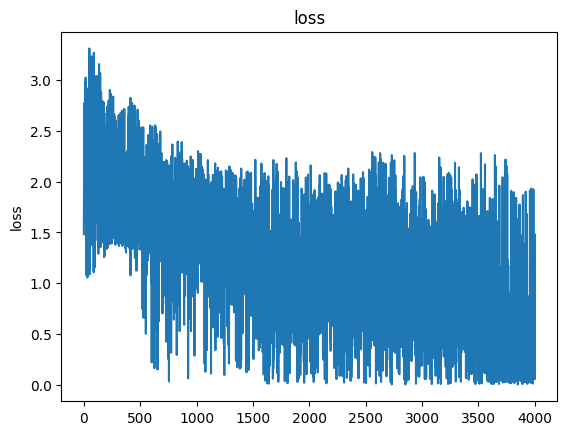

In [37]:
import logging; logging.basicConfig(level=logging.INFO, force=True)

curve = CurveHook()
training_parameters = Training_parameters(n_epochs=4)

with Session(db_engine) as db_session:
    experiment = DBExperiment(name="test_experiment", )
    db_session.add(experiment)
    trainer = Trainer(model, loader, training_parameters=training_parameters, device="cpu",
        step_hooks = [ 
            TqdmHook(),
            LoggerHook(interval=10),
            curve
        ],
        database=db_session, 
        db_experiment=experiment, )
    experiment_id = experiment.id
    trainer_id = trainer.id
    trainer.train()
curve.draw()

Now check that we're able to resume training

In [41]:
new_training_parameters = copy(training_parameters)
new_training_parameters.n_epochs = 5
with Session(db_engine) as db_session:
    
    trainer = Trainer(model, loader, 
                      training_parameters=training_parameters, device="cpu",
        step_hooks = [ 
            TqdmHook(),
            LoggerHook(interval=10),
            curve
        ],
        database=db_session, 
        db_experiment=experiment_id, 
        resume_from=trainer_id)
    trainer.train()

Epoch 3:   0%|          | 0/4000 [00:00<?, ?it/s]

/home/tris/Devoirs/research/implementations/tb_ml/ml_lib/models/base_classes.py:308: SAWarning: Object of type <Training_step> not in session, add operation along 'Training_run.steps' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return session.get(Database_Model, self.id)
INFO:root:iteration= 4000, loss= 0.9789570569992065, 
INFO:root:iteration= 4010, loss= 0.3779286742210388, 
INFO:root:iteration= 4020, loss= 0.7549309730529785, 
INFO:root:iteration= 4030, loss= 0.46428775787353516, 
INFO:root:iteration= 4040, loss= 0.05195813626050949, 
INFO:root:iteration= 4050, loss= 0.1471388041973114, 
INFO:root:iteration= 4060, loss= 1.46470046043396, 
INFO:root:iteration= 4070, loss= 0.0808134526014328, 
INFO:root:iteration= 4080, loss= 0.3182894289493561, 
INFO:root:iteration= 4090, loss= 1.5281829833984375, 
INFO:root:iteration= 4100, loss= 1.0645856857299805, 
INFO:root:iteration=